In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [28]:
# {'a': {'b': 10, 'c': 20}, 'b': {'a': 10, 'd': 20}, 'c': {'a': 20, 'd': 30}, 'd': {'b': 20, 'c': 30}}
# ['a', 'b', 'c', 'd'], np.array([[0, 10, 20, inf], [10, 0, inf, 20], [20, inf, 0, 30], [inf, 20, 30, 0]])

class Graph:
    def __init__(self):
        "Неориентированный взвешенный граф."
        self.graph = {}

    def add_node(self, v):
        "Добавление вершины с именем v."
        self.graph[v] = {}
    
    def set_edge(self, u, v, w):
        "Задание ребра весом w между u и v."
        self.graph[u][v] = w
        self.graph[v][u] = w

    def get_edge(self, u, v):
        "Получение веса ребра между u и v."
        return self.graph[u][v]

    @property
    def nodes(self):
        "Список вершин."
        return self.graph.keys()
    
    def _dfs(self, visited, v):
        "Рекурсивный dfs"
        visited.add(v)
        for u in self.graph[v].keys():
            if u not in visited:
                self._dfs(visited, u) 
    
    def is_connected(self):
        "Проверка связности."
        visited = set()
        self._dfs(visited, next(iter(self.graph.keys())))
        
        nodes = set(self.nodes)
        
        if visited != nodes:
            return False
        return True
        


class Circuit(Graph):
    def probe_field(self, u, v, u_voltage=0, v_voltage=1):
        """
        Расчёт поля потенциалов при подключении источника тока в вершины u и v.
        Возвращает словарь {вершина: потенциал}.
        """
        a, b = self._equations(u, v, u_voltage, v_voltage)
        return dict(zip(self.nodes, LA.solve(a, b)))
    
    
    def calculate_currents(self, voltages):
        """
        Расчёт значений токов, исходя из значений поля потенциалов.
        Возващает словарь {(вершина, вершина): ток}.
        """
        currents = dict()
        for v in self.nodes:
            for u in self.graph[v].keys():
                currents[(v, u)] = (voltages[v] - voltages[u]) / self.get_edge(u, v)
                currents[(u, v)] = -currents[(v, u)]
        return currents 
    
    
    def equivalent_resistance(self, u, v):
        """
        Расчёт эквивалентного сопротивления между вершинами u и v.
        """
        voltages = self.probe_field(u, v)
        currents = self.calculate_currents(voltages)
        
        Isum = 0
        for adj in self.graph[u].keys():
            Isum += currents[(u, adj)]
        Isum = -Isum    
        return 1 / Isum

    
    def _equations(self, a, b, aV, bV):
        """
        Возвращает систему уравнений "Первое правило Кирхгофа".
        """
        self.enumDict = dict(zip(self.nodes, range(len(self.nodes))))
 
        size = len(self.nodes)
        equationMatrix = np.zeros((size, size))
        
        for v in self.nodes:
            for u in self.graph[v].keys():
                equationMatrix[self.enumDict[v]][self.enumDict[v]] -= 1/self.get_edge(u, v)
                equationMatrix[self.enumDict[v]][self.enumDict[u]] += 1/self.get_edge(u, v)
        
        equationMatrix[self.enumDict[a]] = np.zeros(size)
        equationMatrix[self.enumDict[b]] = np.zeros(size)
        equationMatrix[self.enumDict[a]][self.enumDict[a]] = 1
        equationMatrix[self.enumDict[b]][self.enumDict[b]] = 1
        
        vectorOfInhomogeneity = np.zeros(size)
        vectorOfInhomogeneity[self.enumDict[a]] = aV
        vectorOfInhomogeneity[self.enumDict[b]] = bV
        
        return (equationMatrix, vectorOfInhomogeneity)

    
class Grid(Circuit):
    def __init__(self, width, height, resistance):
        """
        Прямоугольная решётка из width горизонтальных узлов и height вертикальных.
        """
        super().__init__()
        
        for x in range(width):
            for y in range(height):
                self.add_node((x, y))
        
        for x in range(width - 1):
            for y in range(height - 1):
                self.set_edge((x, y), (x + 1, y), resistance)
                self.set_edge((x, y), (x, y + 1), resistance)
        
        for y in range(height - 1):
            self.set_edge((width - 1, y), (width - 1, y + 1), resistance)
        
        for x in range(width - 1):
            self.set_edge((x, height - 1), (x + 1, height - 1), resistance)
    
    def plot_currents(self, currents):
        """
        Нарисовать картинку токов по заданному их распределению.
        """
        for dot in self.nodes:
            plt.scatter(dot[0], dot[1], color="b", s = 3)
            
        maximumCurrent = max(dict(currents).values())    
        for edge in currents:
            if(currents[edge] > 0):
                v = edge[0]
                u = edge[1]
                dx = u[0] - v[0]
                dy = u[1] - v[1]  
                plt.arrow(v[0], v[1], dx, dy, width = 0.1, length_includes_head = True, alpha = currents[edge] / maximumCurrent)
                
                
                

# Проверка примеров из презентаций

### Пример первый - небольшая цепь с последовательным подключением

In [24]:
gr = Circuit()

gr.add_node('a')
gr.add_node('b')
gr.add_node('c')
gr.add_node('d')

gr.set_edge('a', 'b', 10)
gr.set_edge('a', 'c', 20)
gr.set_edge('b', 'd', 20)
gr.set_edge('d', 'c', 30)

print("Граф связный?")
print(gr.is_connected())
print()

# Результирующее сопротивление, пощитанное в ручную, было равно 150/8 = 18.75
print("Результирующее сопротивление цепи = {}".format(gr.equivalent_resistance('a', 'd')))

Граф связный?
True

Результирующее сопротивление цепи = 18.75


я считал общее сопротивление по току, выходящему из истока. Если считать по току из стока, то число будет ~ таким же, только из-за точности вычислений, будет отличаться в 10^-6 и меньших порядках 

### Пример второй - цепь с параллельным подключением

При данной реализации появилась проблема с параллельным подключением. Она заключалась в том, что элементы хранятся в словарях, которые хранят только уникальные значения. Поэтому нет возможности пусть между двумя вершинами два ребра. <p>

Я решил, что при построении параллельного подключения, буду резистор разбивать на два ребра с вевсами равными сопротивлению резистора деленное на два. Ребра будут соединяться дополнительной вершиной.
    

In [4]:
gr = Circuit()
"""
Хотим построить цепь из 3 параллельных соединений
между вевршинами a и b

    - - 5(c) - -
    -          -
a - - - 3(d) - - - b
    -          -
    - - 7(e) - -
    
"""
gr.add_node('a')
gr.add_node('b')
gr.add_node('c')
gr.add_node('d')
gr.add_node('e')

gr.set_edge('a', 'c', 5/2)
gr.set_edge('a', 'd', 3/2)
gr.set_edge('a', 'e', 7/2)
gr.set_edge('b', 'c', 5/2)
gr.set_edge('b', 'd', 3/2)
gr.set_edge('b', 'e', 7/2)

print("Граф связный?")
print(gr.is_connected())
print()

# Результирующее сопротивление, пощитанное в ручную, было равно 1.478
print("Результирующее сопротивление цепи = {}".format(gr.equivalent_resistance('a', 'b')))

Граф связный?
True

Результирующее сопротивление цепи = 1.4788732394366195


Данный результат совпадает с вычислением руками. 

### Пример третий - задача с физтех библиотеки 
https://lib.mipt.ru/users/registration/

In [5]:
gr = Circuit()

gr.add_node('a')
gr.add_node('b')

gr.add_node('c1')
gr.add_node('c2')

gr.add_node('d1')
gr.add_node('d2')

gr.add_node('m')
gr.add_node('m1')
gr.add_node('m2')

gr.set_edge('a', 'c1', 3)
gr.set_edge('a', 'c2', 0.5)

gr.set_edge('c1', 'm1', 3)
gr.set_edge('c2', 'm2', 0.5)

gr.set_edge('m1', 'm', 3/2)
gr.set_edge('m1', 'd1', 3/2)
gr.set_edge('m2', 'm', 3/2)
gr.set_edge('m2', 'd2', 3/2)

gr.set_edge('d1', 'b', 3/2)
gr.set_edge('d2', 'b', 3/2)

print("Граф связный?")
print(gr.is_connected())
print()

# Результирующее сопротивление, пощитанное в ручную, было равно 150/8 = 18.75
print("Результирующее сопротивление цепи = {}".format(gr.equivalent_resistance('a', 'b')))

Граф связный?
True

Результирующее сопротивление цепи = 2.5555555555555554


Это число можно представить как 23/9 <p>
Подаем эту дробь как ответ на регистрационную форму. Ура мы прошли)
    


### Пример четвертый - различные Gridы

In [29]:
grid1 = Grid(5, 5, 1)

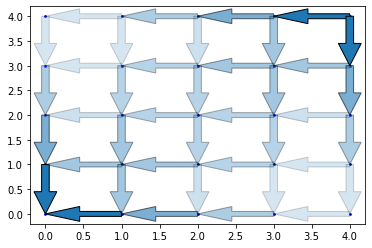

In [30]:
voltages = grid1.probe_field((0, 0), (4, 4))
currents = grid1.calculate_currents(voltages)
grid1.plot_currents(currents)

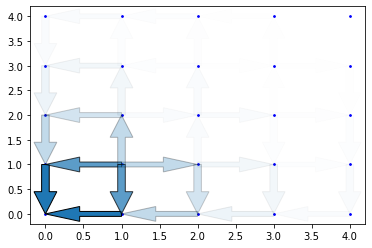

In [31]:
voltages = grid1.probe_field((0, 0), (1, 1))
currents = grid1.calculate_currents(voltages)
grid1.plot_currents(currents)

0.8181818181818185

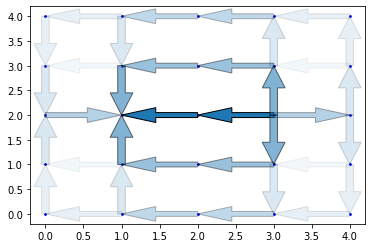

In [56]:
voltages = grid1.probe_field((1, 2), (3, 2))
currents = grid1.calculate_currents(voltages)
grid1.plot_currents(currents)
grid1.equivalent_resistance((1, 2), (3, 2))

#### Бесконечная решетка

In [48]:
size = 101
infinityGrid = Grid(size + 2, size, 1)

In [49]:
dot1 = ((size + 1)/2,(size - 1)/2)
dot2 = ((size + 1)/2 + 1,(size - 1)/2)

0.5000533731505552

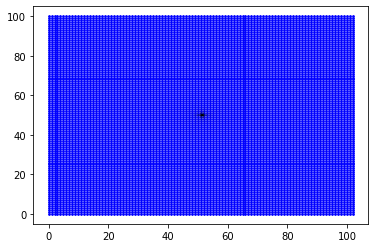

In [50]:
voltages = infinityGrid.probe_field(dot1, dot2)
currents = infinityGrid.calculate_currents(voltages)
infinityGrid.plot_currents(currents)
infinityGrid.equivalent_resistance(dot1, dot2)

In [51]:
dot3 = dot1
dot4 = ((size + 1)/2 + 1,(size - 1)/2 + 1)

0.6367250638358315

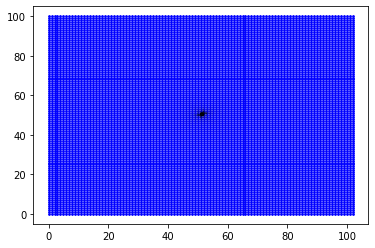

In [52]:
voltages = infinityGrid.probe_field(dot3, dot4)
currents = infinityGrid.calculate_currents(voltages)
infinityGrid.plot_currents(currents)
infinityGrid.equivalent_resistance(dot3, dot4)